# sgd theano 進階版寫法

首先假設一個很簡單的function => y=x

1. 模擬資料一些資料從y=x產生
2. init weights
3. define model，真實世界裡的 <span style='color:red'>f</span> 我們是未知的，這裡我們當作已經知道是y=x，方便用來驗證gradient
4. define cost
5. implement SGD
6. training

In [26]:
%pylab inline
import theano
import theano.tensor as T
#import numpy as np
#import matplotlib.pyplot as plt
import itertools as it

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 把floatX包起來方便使用

In [27]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

### 模擬資料

In [28]:
x_data = floatX(np.array(np.linspace(-5.0, 5.0, 100)))
y_data = floatX(np.array(x_data))

### 初始化權重

In [29]:
w = theano.shared(-1.)

### 定義model / function

這裡要特別注意，因為是跑SGD是一筆一筆資料跑而且我們資料只有一維，要將x宣告為theano <span style='color:red'>scalar()</span>

In [30]:
### model
x = T.scalar()
y = w*x

如果要測試model output可以theano function一下

In [31]:
f = theano.function([x], y)
print f(10)

-10.0


那如果x是二維或是多維以上呢?那就要將x宣告為theano <span style='color:red'>vector()</span>

In [32]:
#假設x是二維，w也要是二維(當然)
w2 = theano.shared(floatX(np.array([-1.,-1.])))
print "w2 我是vector"
print w2
print ""
x2 = theano.shared(floatX(np.array([1.,1.])))
print "x2 我也是vector"
print x2
print ""
print "Element Wise 相乘，我還是vector"
print (w2*x2).eval()
print (w2*x2).type()
print ""
print "矩陣相乘dot，我變成scalar了，這樣才能配合y_hat也是scalar，順利做gradient"
print (T.dot(w2,x2)).eval()
print (T.dot(w2,x2)).type()

w2 我是vector
<TensorType(float64, vector)>

x2 我也是vector
<TensorType(float64, vector)>

Element Wise 相乘，我還是vector
[-1. -1.]
<TensorType(float64, vector)>

矩陣相乘dot，我變成scalar了，這樣才能配合y_hat也是scalar，順利做gradient
-2.0
<TensorType(float64, scalar)>


### 實作SGD
* 用izip配合迴圈寫法一次update多個參數，如同下面寫法
* [w1, w1 - 0.01*dw1]
* [w2, w2 - 0.01*dw2]
* ...
* [b, b - 0.01*db]

In [33]:
### gradients
def sgd(params, grads, lr): 
    updates = []
    for p, g in it.izip(params, grads):      
        updates.append([p, p - lr*g])    
    return updates

### 定義cost/error/loss
#### 很重要，取決你怎麼餵資料算cost，SGD/MiniBatch/All Data cost算法都不一樣)

要特別注意cost function是<span style='color:red'>不用做sum</span>的(別照抄把全部data看過一輪的cost function)，因為是一筆做一次gradient

In [34]:
### cost/error/loss
y_hat = T.scalar()
#cost = T.sum((y-y_hat)**2)
cost = (y-y_hat)**2

### 定義train的theano function
* 對cost的w偏微分
* 輸入x, y_hat
* 輸出cost, w
* 更新用sgd

In [35]:
dw = T.grad(cost, w)
train = theano.function(inputs=[x, y_hat],
                        outputs=[cost,w],
                        updates=sgd([w], [dw], 0.001))

### 洗牌一下

In [36]:
# shuffle idx for Stochastic (不用作也沒關係，有可能data本身就是沒有順序性了)
idx = np.arange(x_data.shape[0])
np.random.shuffle(idx)

### 開始training

* cost_result第一個是cost變化，第二個是w的變化

In [37]:
# training
cost_list = []
for t in range(4):    
    for i in idx:
        cost_result = train(x_data[i], y_data[i])        
        cost_list.append(cost_result[0])
    print cost_result

[array(0.23693878960409676), array(0.6430400362188393)]
[array(0.007491674171752809), array(0.9365267309182803)]
[array(0.00023687629192961854), array(0.9887134236421247)]
[array(7.489698082423297e-06), array(0.9979930637302116)]


### 畫圖看結果

* SGD不是像GD一樣是看最陡的方向，而是取一筆後就走了，會亂跳，但是會慢慢收斂
* SGD比GD快(但是如果在<span style='color:red'>GPU平行運算</span>的環境下，反而是mini batch或all data比較快，因為矩陣相乘靠GPU平行運算下 (ref ML2016 Hello World of deep learning)

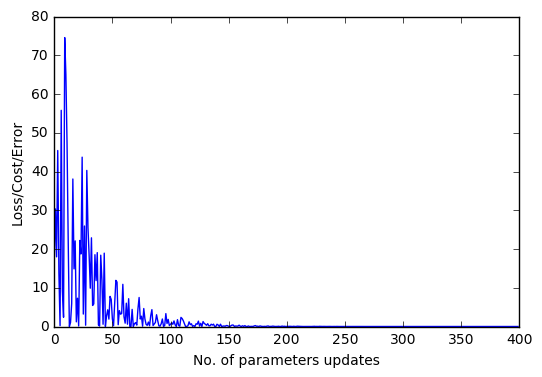

In [38]:
plt.plot(cost_list)
plt.xlabel("No. of parameters updates")
plt.ylabel("Loss/Cost/Error")
plt.show()

### 如果不做shuffle呢???

In [39]:
#把w重新初始化
w.set_value(-1.)

idx = np.arange(x_data.shape[0])

# training
cost_list = []
for t in range(4):    
    for i in idx:
        cost_result = train(x_data[i], y_data[i])        
        cost_list.append(cost_result[0])
    print cost_result

[array(3.5034466188051168), array(0.6256500771307617)]
[array(0.1107740973526242), array(0.9334345142427025)]
[array(0.0035025225098115694), array(0.9881635773819764)]
[array(0.00011074487831468541), array(0.9978952921503003)]


### 結果好平滑，為什麼?

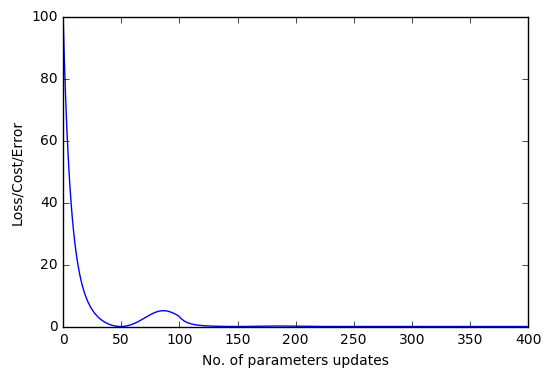

In [40]:
plt.plot(cost_list)
plt.xlabel("No. of parameters updates")
plt.ylabel("Loss/Cost/Error")
plt.show()

### 因為我們cost function是長這樣(convex)，我們是從最左邊慢慢往下走，而不是shuffle亂走，結果就會很平滑
- 把w重新初始化-1，實際f的w=1，這樣就能畫出每一筆x計算出square error的結果

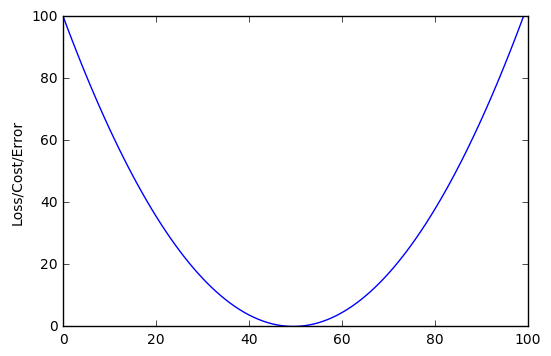

In [41]:
w.set_value(-1.)

cost_f_list = []
cost_f = theano.function([x, y_hat], cost)
for i in range(x_data.shape[0]):
    cost_f_list.append(cost_f(x_data[i], y_data[i]))
    
plt.plot(cost_f_list)
plt.ylabel("Loss/Cost/Error")
plt.show()